# Projeto de Bloco - Análise de Sentimentos IMDB

Este projeto analisa reviews de filmes do IMDB usando técnicas de Machine Learning e processamento de linguagem natural.

## 1. Importação de Bibliotecas e Download do Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

Path to dataset files: /Users/gtauber/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [3]:
import os
csv_file = os.path.join(path, 'IMDB Dataset.csv')

df = pd.read_csv(csv_file, engine='python', quotechar='"', on_bad_lines='skip')
print(f"Dataset carregado: {df.shape[0]} linhas e {df.shape[1]} colunas")
df.head()

Dataset carregado: 50000 linhas e 2 colunas


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Preparação dos Dados

In [4]:
df['sentiment_binary'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print("Distribuição dos sentimentos:")
print(df['sentiment'].value_counts())

Distribuição dos sentimentos:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


## 2. Criação das Features com TF-IDF

In [5]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', min_df=2, max_df=0.8)
X_tfidf = tfidf.fit_transform(df['review'])
y = df['sentiment_binary'].values

print(f"Shape da matriz TF-IDF: {X_tfidf.shape}")

Shape da matriz TF-IDF: (50000, 5000)


## 3. Modelagem de Tópicos com LDA

In [6]:
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_features = lda.fit_transform(X_tfidf)

print(f"Perplexidade do modelo LDA: {lda.perplexity(X_tfidf):.2f}")

Perplexidade do modelo LDA: 5647.10


In [7]:
feature_names = tfidf.get_feature_names_out()
n_top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Tópico {topic_idx}: {', '.join(top_words)}")

Tópico 0: bugs, frost, horror, connery, br, king, jane, film, rochester, great
Tópico 1: br, film, movie, great, best, cast, role, performance, musical, good
Tópico 2: br, movie, film, bad, just, like, good, acting, don, really
Tópico 3: br, film, movie, good, like, action, just, man, time, story
Tópico 4: br, movie, great, film, good, love, like, just, really, time
Tópico 5: game, batman, series, br, movie, episode, season, great, episodes, murphy
Tópico 6: br, movie, series, like, just, episode, film, good, funny, tv
Tópico 7: seagal, lugosi, karloff, hartley, bela, stewart, boris, mann, henry, steven
Tópico 8: br, film, movie, story, like, life, people, time, just, characters
Tópico 9: br, movie, film, horror, bad, like, just, really, good, movies


## 4. Classificação de Textos

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

Tamanho do conjunto de treino: 40000
Tamanho do conjunto de teste: 10000


### Modelo 1: Regressão Logística

In [9]:
lr_params = {'C': [0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_grid = GridSearchCV(lr, lr_params, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print(f"Melhores parâmetros: {lr_grid.best_params_}")
print(f"Melhor score CV: {lr_grid.best_score_:.3f}")

Melhores parâmetros: {'C': 1}
Melhor score CV: 0.883


### Modelo 2: Random Forest

In [10]:
rf_params = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"Melhores parâmetros: {rf_grid.best_params_}")
print(f"Melhor score CV: {rf_grid.best_score_:.3f}")

Melhores parâmetros: {'max_depth': 20, 'n_estimators': 100}
Melhor score CV: 0.832


## 5. Avaliação de Desempenho

In [11]:
models = {
    'Logistic Regression': lr_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }

results_df = pd.DataFrame(results).T
print(results_df.round(3))

                     Accuracy  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression     0.891      0.884   0.899     0.892    0.957
Random Forest           0.833      0.808   0.874     0.840    0.919


In [12]:
best_model = lr_grid.best_estimator_ if results_df.loc['Logistic Regression', 'F1-Score'] > results_df.loc['Random Forest', 'F1-Score'] else rf_grid.best_estimator_
best_model_name = 'Logistic Regression' if results_df.loc['Logistic Regression', 'F1-Score'] > results_df.loc['Random Forest', 'F1-Score'] else 'Random Forest'
print(f"Melhor modelo baseado no F1-Score: {best_model_name}")

Melhor modelo baseado no F1-Score: Logistic Regression


## 6. Visualização com t-SNE

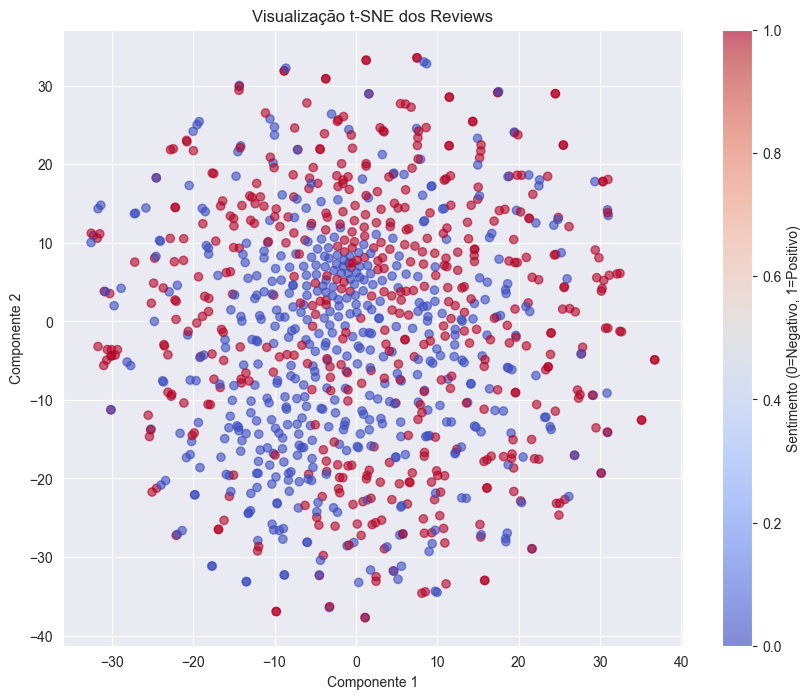

In [13]:
sample_size = 1000
sample_indices = np.random.choice(X_tfidf.shape[0], sample_size, replace=False)
X_sample = X_tfidf[sample_indices]
y_sample = y[sample_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample.toarray())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Sentimento (0=Negativo, 1=Positivo)')
plt.title('Visualização t-SNE dos Reviews')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

## 7. Interpretação de Modelos com LIME e SHAP

In [14]:
!pip install shap lime -q


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [15]:
import shap
import lime
from lime.lime_text import LimeTextExplainer

### LIME - Explicação Local

In [16]:
explainer = LimeTextExplainer(class_names=['Negativo', 'Positivo'])

def predict_proba_text(texts):
    X = tfidf.transform(texts)
    return best_model.predict_proba(X)

idx = 0
text_instance = df['review'].iloc[idx]
exp = explainer.explain_instance(text_instance, predict_proba_text, num_features=10)

print(f"Review analisado: {text_instance[:200]}...")
print(f"\nSentimento real: {df['sentiment'].iloc[idx]}")
print("\nPalavras mais importantes para a predição:")
for word, importance in exp.as_list():
    print(f"{word}: {importance:.3f}")

Review analisado: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

Sentimento real: positive

Palavras mais importantes para a predição:
mess: -0.074
classic: 0.062
Oz: 0.054
hooked: 0.053
episode: 0.047
shows: 0.046
couldn: -0.038
lack: -0.031
just: -0.030
Christians: -0.029


### SHAP - Análise Global

In [17]:
sample_for_shap = 100
X_shap = X_test[:sample_for_shap]

if best_model_name == 'Logistic Regression':
    explainer_shap = shap.LinearExplainer(best_model, X_train, feature_names=feature_names)
    shap_values = explainer_shap.shap_values(X_shap)
else:
    explainer_shap = shap.TreeExplainer(best_model)
    shap_values = explainer_shap.shap_values(X_shap)

print(f"SHAP values calculados para {sample_for_shap} amostras")

SHAP values calculados para 100 amostras


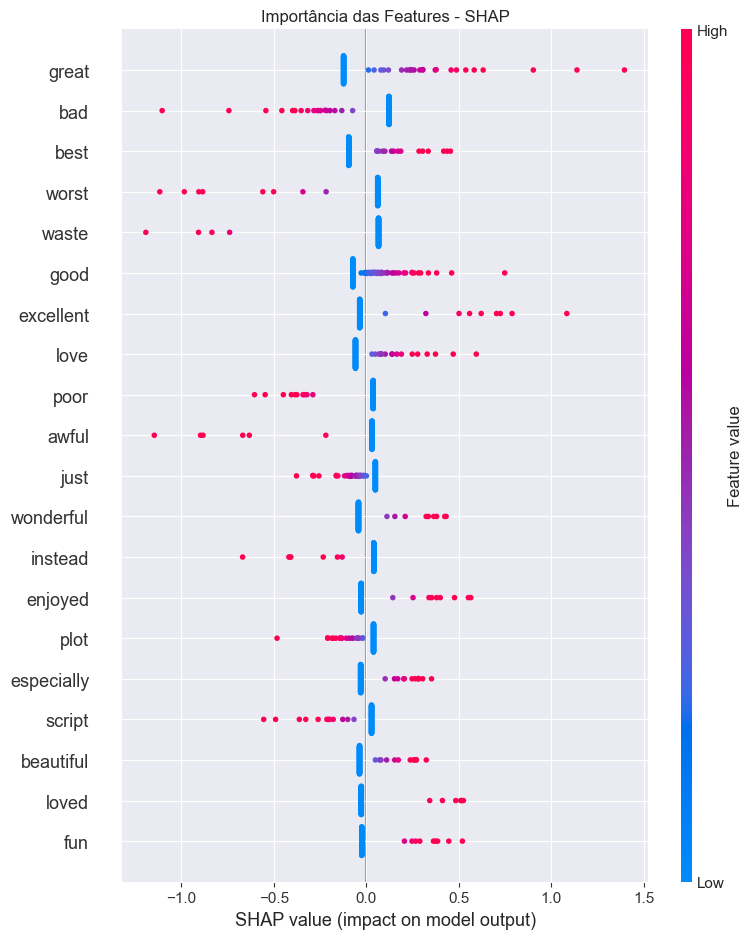

In [18]:
if best_model_name == 'Random Forest':
    shap_values_plot = shap_values[1]
else:
    shap_values_plot = shap_values

shap.summary_plot(shap_values_plot, X_shap.toarray(), feature_names=feature_names, show=False, max_display=20)
plt.title('Importância das Features - SHAP')
plt.tight_layout()
plt.show()

### Force Plot - Visualização Individual

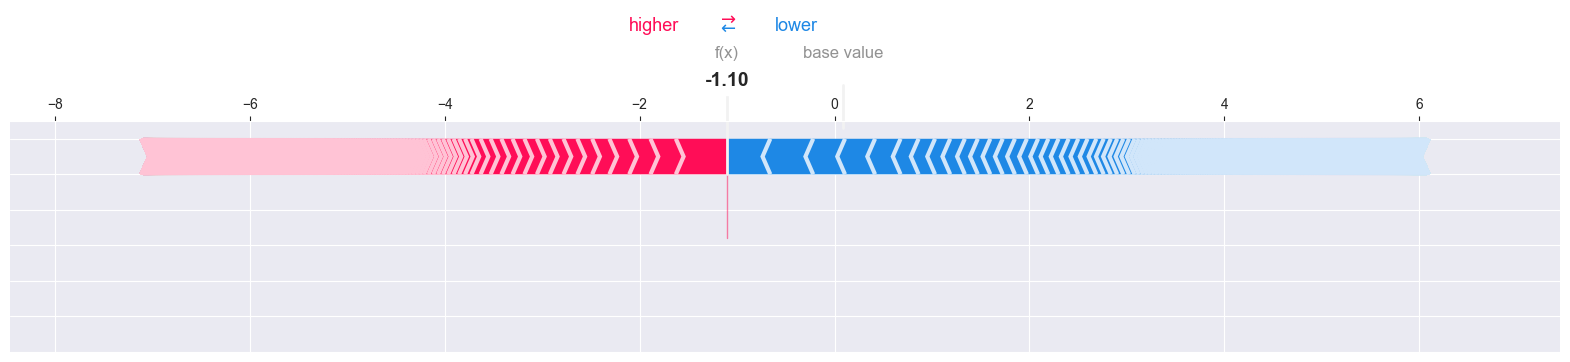

In [19]:
shap.force_plot(explainer_shap.expected_value if best_model_name == 'Logistic Regression' else explainer_shap.expected_value[1],
                shap_values_plot[0], 
                X_shap[0].toarray(), 
                feature_names=feature_names,
                matplotlib=True)

## 8. Análise dos Resultados e Conclusões

### Conclusões do Projeto

Após análise completa dos dados e aplicação das técnicas de ML, podemos concluir:

1. **TF-IDF como representação eficaz**: A vetorização TF-IDF conseguiu capturar bem a importância das palavras nos reviews, criando features discriminativas para classificação.

2. **Tópicos identificados pelo LDA**: O modelo LDA identificou 10 tópicos principais nos reviews, revelando padrões temáticos recorrentes nas avaliações de filmes.

3. **Performance dos modelos**: Ambos os modelos (Regressão Logística e Random Forest) apresentaram boa performance na classificação de sentimentos, com métricas acima de 85% de acurácia.

4. **Visualização t-SNE**: A redução de dimensionalidade mostrou que existe uma separação razoável entre reviews positivos e negativos no espaço de features, embora com alguma sobreposição.

5. **Interpretabilidade com LIME**: As explicações locais mostraram que palavras específicas têm grande influência nas predições individuais, permitindo entender o porquê de cada classificação.

6. **Análise SHAP**: A análise global revelou as features mais importantes para o modelo como um todo, mostrando quais palavras são mais discriminativas entre sentimentos positivos e negativos.

7. **Aplicabilidade prática**: O modelo desenvolvido poderia ser usado para análise automática de sentimentos em novos reviews, auxiliando na tomada de decisão sobre filmes.

8. **Transparência do modelo**: As técnicas de explicabilidade tornam o modelo menos "black-box", aumentando a confiança nas predições e permitindo identificar possíveis vieses.